C:\Users\ghala\AppData\Local\Temp\ipykernel_41848\3209655935.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['price_SAR'].fillna(df['price_SAR'].mean(), inplace=True)


Features used for training: ['price_SAR', 'notable_effects_acne-free', 'notable_effects_acne-spot', 'notable_effects_anti-aging', 'notable_effects_balancing', 'notable_effects_black-spot', 'notable_effects_brightening', 'notable_effects_hydrating', 'notable_effects_moisturizing', 'notable_effects_no-whitecast', 'notable_effects_oil-control', 'notable_effects_pore-care', 'notable_effects_refreshing', 'notable_effects_skin-barrier', 'notable_effects_soothing', 'notable_effects_uv-protection']
Silhouette Score: 0.357
Total WSS (Inertia): 1005.09

Cluster to Skin Type Mapping:
Cluster 0: Oily
Cluster 1: Dry
Cluster 2: Oily
Cluster 3: Dry
Cluster 4: Oily


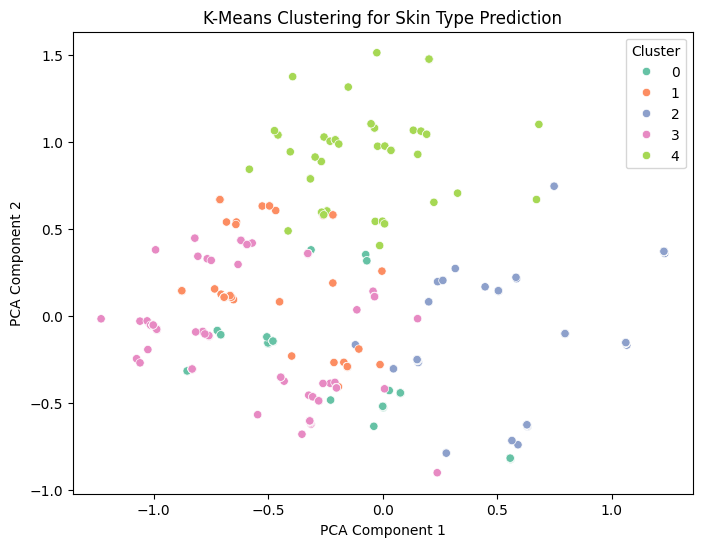


Predicted Skin Type for New Product: Dry
Silhouette Score: 0.357
Total WSS (Inertia): 1005.09
BCubed Precision: 0.335
BCubed Recall: 0.272


In [ ]:
# ============================================
# PHASE 3: CLUSTERING TO PREDICT SKIN TYPE
# ============================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from collections import Counter

# ============================================
# LOAD DATASET
file_path = "Dataset/processed_file.csv"
df = pd.read_csv(file_path)

# ============================================
# HANDLE MISSING VALUES
# Fill missing price values with the mean price
df['price_SAR'].fillna(df['price_SAR'].mean(), inplace=True)

# ============================================
# FEATURE ENGINEERING (WITHOUT SKIN TYPE LABELS)
# We remove skin type labels to apply unsupervised learning

skin_type_columns = ['Sensitive', 'Combination', 'Oily', 'Dry', 'Normal']
df_clustering = df.drop(columns=skin_type_columns)  

# Select notable effects & price as features for clustering
notable_effects_columns = [col for col in df.columns if col.startswith('notable_effects_')]
input_features = ['price_SAR'] + notable_effects_columns
X = df[input_features]
# Print the exact feature names used in training
print("Features used for training:", list(X.columns))


# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# ============================================
# APPLY K-MEANS CLUSTERING
k = 6  # Since we have 5 skin types
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to dataframe
df['cluster'] = clusters

# ============================================
# CLUSTER EVALUATION

# 1️⃣ Silhouette Score - Measures how well-separated the clusters are
sil_score = silhouette_score(X_scaled, clusters)
print(f"Silhouette Score: {sil_score:.3f}")

# 2️⃣ Total WSS (Within-Cluster Sum of Squares) - Measures cluster compactness
print(f"Total WSS (Inertia): {kmeans.inertia_:.2f}")

# ============================================
# ASSIGNING SKIN TYPES TO CLUSTERS

# Find the most common skin type in each cluster
cluster_skin_map = {}
for cluster_id in range(k):
    cluster_data = df[df['cluster'] == cluster_id][skin_type_columns]
    majority_skin_type = cluster_data.sum().idxmax()  # Most frequent skin type
    cluster_skin_map[cluster_id] = majority_skin_type

# Print the cluster-to-skin-type mapping
print("\nCluster to Skin Type Mapping:")
for cluster, skin_type in cluster_skin_map.items():
    print(f"Cluster {cluster}: {skin_type}")

# ============================================
# VISUALIZE CLUSTERS
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='Set2')
plt.title("K-Means Clustering for Skin Type Prediction")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

# ============================================
# FUNCTION TO PREDICT SKIN TYPE FOR A NEW PRODUCT
def predict_skin_type(new_product_features, kmeans_model, scaler, cluster_skin_map):
    """
    Predicts the best skin type for a new product.
    
    Parameters:
    - new_product_features: Dictionary with notable effects (binary 0/1) and price
    - kmeans_model: Trained K-Means clustering model
    - scaler: Trained MinMaxScaler used during training
    - cluster_skin_map: Dictionary mapping clusters to skin types

    Returns:
    - Predicted skin type
    """
    input_df = pd.DataFrame([new_product_features])
    input_scaled = scaler.transform(input_df)
    predicted_cluster = kmeans_model.predict(input_scaled)[0]
    
    return cluster_skin_map.get(predicted_cluster, "Unknown")

# ============================================
# EXAMPLE: Predict Skin Type for a New Product
# Get the correct feature names from training
correct_feature_names = list(X.columns)

# Initialize new product dictionary with correct feature names, default to 0
new_product = {feature: 0 for feature in correct_feature_names}

# Manually set values based on product properties
new_product.update({
    'price_SAR': 50,  # Example price
    'notable_effects_hydrating': 1,
    'notable_effects_brightening': 0,
    'notable_effects_acne-spot': 0,  # Match the actual name
    'notable_effects_anti-aging': 1,  # Match the actual name
    'notable_effects_moisturizing': 1,
    'notable_effects_oil-control': 0,
    'notable_effects_pore-care': 0,
    'notable_effects_refreshing': 0,
    'notable_effects_skin-barrier': 1,
    'notable_effects_soothing': 0,
    'notable_effects_uv-protection': 0
})

# Convert to DataFrame & scale it using the same scaler
input_df = pd.DataFrame([new_product])
input_scaled = scaler.transform(input_df)

# Predict skin type
predicted_cluster = kmeans.predict(input_scaled)[0]
predicted_skin_type = cluster_skin_map.get(predicted_cluster, "Unknown")

print(f"\nPredicted Skin Type for New Product: {predicted_skin_type}")
from sklearn.metrics import silhouette_score
from collections import defaultdict

# ============================================
# 1️⃣ Silhouette Coefficient
sil_score = silhouette_score(X_scaled, clusters)
print(f"Silhouette Score: {sil_score:.3f}")

# ============================================
# 2️⃣ Total Within-Cluster Sum of Squares (WSS)
print(f"Total WSS (Inertia): {kmeans.inertia_:.2f}")

# ============================================
# 3️⃣ BCubed Precision & Recall
def bcubed_precision_recall(true_labels, cluster_labels):
    """
    Computes BCubed Precision & Recall for clustering evaluation.
    - Precision: Measures purity of clusters.
    - Recall: Measures consistency of true labels in a cluster.
    """
    n = len(true_labels)
    correct_precision = 0
    correct_recall = 0

    # Precompute label & cluster assignments
    label_groups = defaultdict(set)
    cluster_groups = defaultdict(set)
    
    for i, (label, cluster) in enumerate(zip(true_labels, cluster_labels)):
        label_groups[label].add(i)
        cluster_groups[cluster].add(i)

    for i in range(n):
        label = true_labels[i]
        cluster = cluster_labels[i]

        label_set = label_groups[label]
        cluster_set = cluster_groups[cluster]
        intersection = label_set.intersection(cluster_set)

        precision_i = len(intersection) / len(cluster_set)
        recall_i = len(intersection) / len(label_set)

        correct_precision += precision_i
        correct_recall += recall_i

    precision = correct_precision / n
    recall = correct_recall / n
    return precision, recall

# Convert skin type columns to single labels for BCubed evaluation
true_labels_encoded = df[skin_type_columns].idxmax(axis=1).astype(str)

# Compute BCubed Precision & Recall
bcubed_p, bcubed_r = bcubed_precision_recall(true_labels_encoded, clusters)
print(f"BCubed Precision: {bcubed_p:.3f}")
print(f"BCubed Recall: {bcubed_r:.3f}")
